# Abstract

The goal of this notebook is to understand how well the simulations are in the first place. In our example, we use a network where the policy was implemented in district 1-7. 

First thing:
1. Create a gdf with the links and the stats of the average case.
2. Create a gdf with the links and the stats of each random seed to the simulation. 


In [1]:
import pandas as pd
import os
import glob
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import help_functions as hf
import processing_from_eqasim as pio

file_path = '../../data/test_data/sim_networks_d_1-7/'

def get_subdirs(full_path: str):
    subdirs_pattern = os.path.join(full_path, '*')
    subdirs_list = list(set(glob.glob(subdirs_pattern)))
    subdirs_list.sort()
    return subdirs_list

policy_in_d_subdir= get_subdirs(file_path)

In [2]:

# Define the relative path to the GeoJSON file
geojson_file_path = '../../data/test_data/pop_1pm_basecase_mean_links_NEW.geojson'

# Read the GeoJSON file into a GeoDataFrame
gdf_basecase_mean = gpd.read_file(geojson_file_path)

In [3]:
random_seed_2_gdf_policy_in_d_output_links = pio.create_dic_seed_2_output_links(subdir=policy_in_d_subdir)
random_seed_2_gdf_policy_in_d_eqasim_trips = pio.create_dic_seed_2_eqasim_trips(subdir=policy_in_d_subdir)
gdf_output_links_values = list(random_seed_2_gdf_policy_in_d_output_links.values())
gdf_policy_in_d_mean = pio.compute_average_or_median_geodataframe(geodataframes=gdf_output_links_values, column_name="vol_car", is_mean=True)
gdf_policy_in_d_mean = gdf_policy_in_d_mean.rename(columns={"osm:way:highway": "highway"})

In [4]:
gdf_combined_capacity = {}

for seed, gdf_seed_i in random_seed_2_gdf_policy_in_d_output_links.items():
    # Create a copy of gdf_basecase_mean
    gdf_combined_seed = gdf_basecase_mean.copy()
    
    # Merge the vol_car from gdf_seed_i based on the 'link' column
    gdf_combined_seed = gdf_combined_seed.merge(
        gdf_seed_i[['link', 'vol_car', 'capacity']].rename(columns={'vol_car': 'vol_car_seed', 'capacity': 'capacity_seed'}),
        on='link',
        how='left'
    )
    
    # Calculate the 'car volume difference'
    gdf_combined_seed['car_volume_difference'] = gdf_combined_seed['vol_car_seed'] - gdf_combined_seed['vol_car']
    
    # Calculate the 'capacity difference'
    gdf_combined_seed['capacity_reduction'] = gdf_combined_seed['capacity_seed'] - gdf_combined_seed['capacity']
    # gdf_combined_seed['capacity_reduction_rounded'] = gdf_combined_seed['capacity_difference'].round(decimals=3)
    gdf_combined_seed['highway'] = gdf_combined_seed['highway'].map(hf.highway_mapping)

    # Store the combined gdf in the dictionary
    gdf_combined_capacity[seed] = gdf_combined_seed

# Display the combined gdf for the first random seed as an example
# gdf_combined_capacity['0'].head(50)

In [8]:
# Create a copy of gdf_basecase_mean
gdf_combined_policy_in_d_mean = gdf_basecase_mean.copy()

# Merge the vol_car from gdf_policy_in_d_mean based on the 'link' column
gdf_combined_policy_in_d_mean = gdf_combined_policy_in_d_mean.merge(
    gdf_policy_in_d_mean[['link', 'vol_car', 'capacity']].rename(columns={'vol_car': 'vol_car_mean', 'capacity': 'capacity_mean'}),
    on='link',
    how='left'
)

# Calculate the 'car volume difference'
gdf_combined_policy_in_d_mean['car_volume_difference'] = gdf_combined_policy_in_d_mean['vol_car_mean'] - gdf_combined_policy_in_d_mean['vol_car']

# Calculate the 'capacity difference'
gdf_combined_policy_in_d_mean['capacity_reduction'] = gdf_combined_policy_in_d_mean['capacity_mean'] - gdf_combined_policy_in_d_mean['capacity']
# gdf_combined_policy_in_d_mean['capacity_reduction_rounded'] = gdf_combined_policy_in_d_mean['capacity_difference'].round(decimals=3)
gdf_combined_policy_in_d_mean['highway'] = gdf_combined_policy_in_d_mean['highway'].map(hf.highway_mapping)

# Store the combined gdf in the dictionary
gdf_combined_capacity['policy_in_d_mean'] = gdf_combined_policy_in_d_mean

# Display the combined gdf for the policy_in_d_mean as an example
# gdf_combined_capacity['policy_in_d_mean'].head(50)

In [12]:
seed = '0'
diff_gdf = gdf_combined_capacity[seed]
diff_mean_gdf = gdf_combined_capacity['policy_in_d_mean']

# Calculate the mean squared error (MSE) for each seed compared to the policy_in_d_mean
mse_results = {}
for seed in gdf_combined_capacity:
    if seed != 'policy_in_d_mean':
        diff_gdf = gdf_combined_capacity[seed]
        mse = np.mean((diff_gdf['car_volume_difference'] - diff_mean_gdf['car_volume_difference']) ** 2)
        mse_results[seed] = mse

# Print the MSE results
for seed, mse in mse_results.items():
    print(f"Seed {seed}: MSE = {mse}")

# Identify where the differences are the largest
for seed in gdf_combined_capacity:
    if seed != 'policy_in_d_mean':
        diff_gdf = gdf_combined_capacity[seed]
        diff_gdf['difference'] = np.abs(diff_gdf['car_volume_difference'] - diff_mean_gdf['car_volume_difference'])
        largest_differences = diff_gdf.nlargest(10, 'difference')
        print(f"Largest differences for seed {seed}:")
        print(largest_differences[['link', 'car_volume_difference', 'difference']])
        
        
# # Research on links with high differences
# high_difference_links = {}
# for seed in gdf_combined_capacity:
#     if seed != 'policy_in_d_mean':
#         diff_gdf = gdf_combined_capacity[seed]
#         diff_gdf['difference'] = np.abs(diff_gdf['car_volume_difference'] - diff_mean_gdf['car_volume_difference'])
#         high_difference_links[seed] = diff_gdf[diff_gdf['difference'] > diff_gdf['difference'].quantile(0.95)]

# # Analyze the characteristics of high difference links
# for seed, high_diff_gdf in high_difference_links.items():
#     print(f"Analysis for seed {seed}:")
#     print("High difference links where capacity_reduction is not small:")
#     print(high_diff_gdf[high_diff_gdf['capacity_reduction'].abs() > 0.1][['link', 'car_volume_difference', 'capacity_reduction', 'highway']])
    
#     print("High difference links where highway is primary, secondary, or tertiary:")
#     print(high_diff_gdf[high_diff_gdf['highway'].isin(['primary', 'secondary', 'tertiary'])][['link', 'car_volume_difference', 'capacity_reduction', 'highway']])

# # Define good predictions
# good_predictions = {}
# for seed in gdf_combined_capacity:
#     if seed != 'policy_in_d_mean':
#         diff_gdf = gdf_combined_capacity[seed]
#         diff_gdf['difference'] = np.abs(diff_gdf['car_volume_difference'] - diff_mean_gdf['car_volume_difference'])
#         good_predictions[seed] = diff_gdf[diff_gdf['difference'] < diff_gdf['difference'].quantile(0.05)]

# # Analyze the characteristics of good predictions
# for seed, good_pred_gdf in good_predictions.items():
#     print(f"Good predictions for seed {seed}:")
#     print(good_pred_gdf[['link', 'car_volume_difference', 'capacity_reduction', 'highway']])



Analysis for seed 0:
High difference links where capacity_reduction is not small:
         link  car_volume_difference  capacity_reduction  highway
543    225107              -4.921569             -1200.0      1.0
565    448868              -6.470588             -1200.0      1.0
570    611917              -0.960784              -600.0      1.0
3407   346141              -4.117647              -600.0      1.0
3408   538513              -0.921569             -1200.0      1.0
...       ...                    ...                 ...      ...
26655  615580               1.686275              -600.0      1.0
26773  605652              -1.725490             -1800.0      1.0
26881  366276              -8.098039             -2400.0      1.0
26893  515755              -1.156863             -1200.0      1.0
27132  275854              -5.784314             -1200.0      1.0

[181 rows x 4 columns]
High difference links where highway is primary, secondary, or tertiary:
Empty DataFrame
Columns: [link

# Visualize the differences of the random seeds and the average case

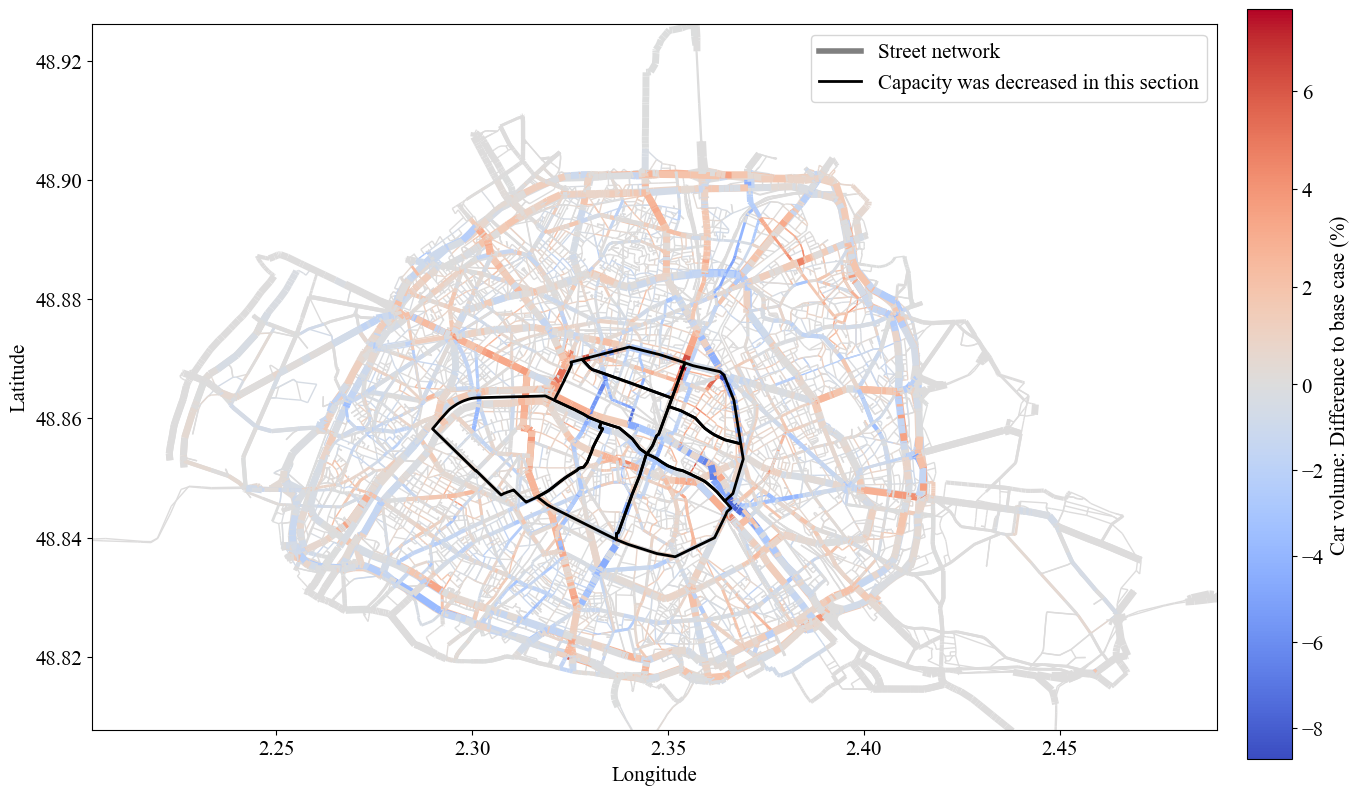

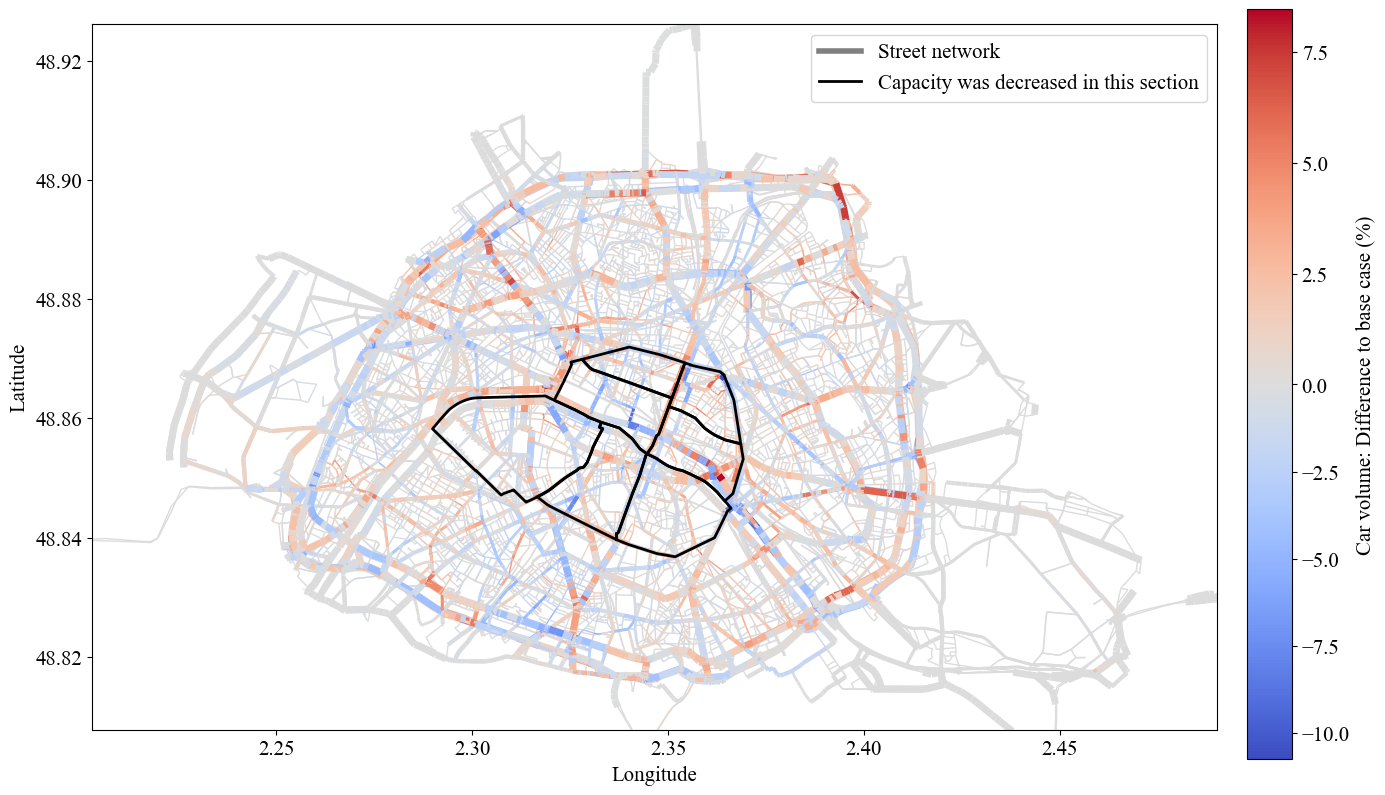

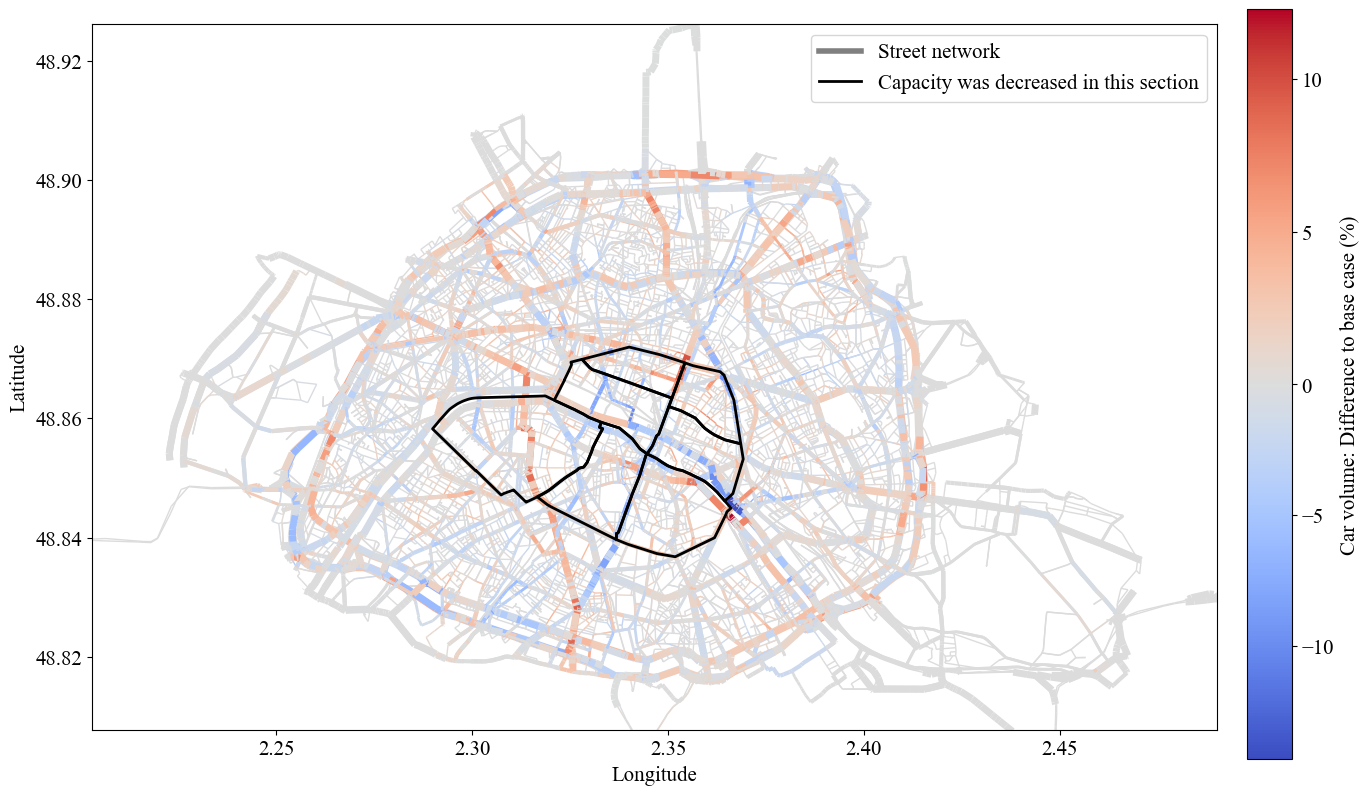

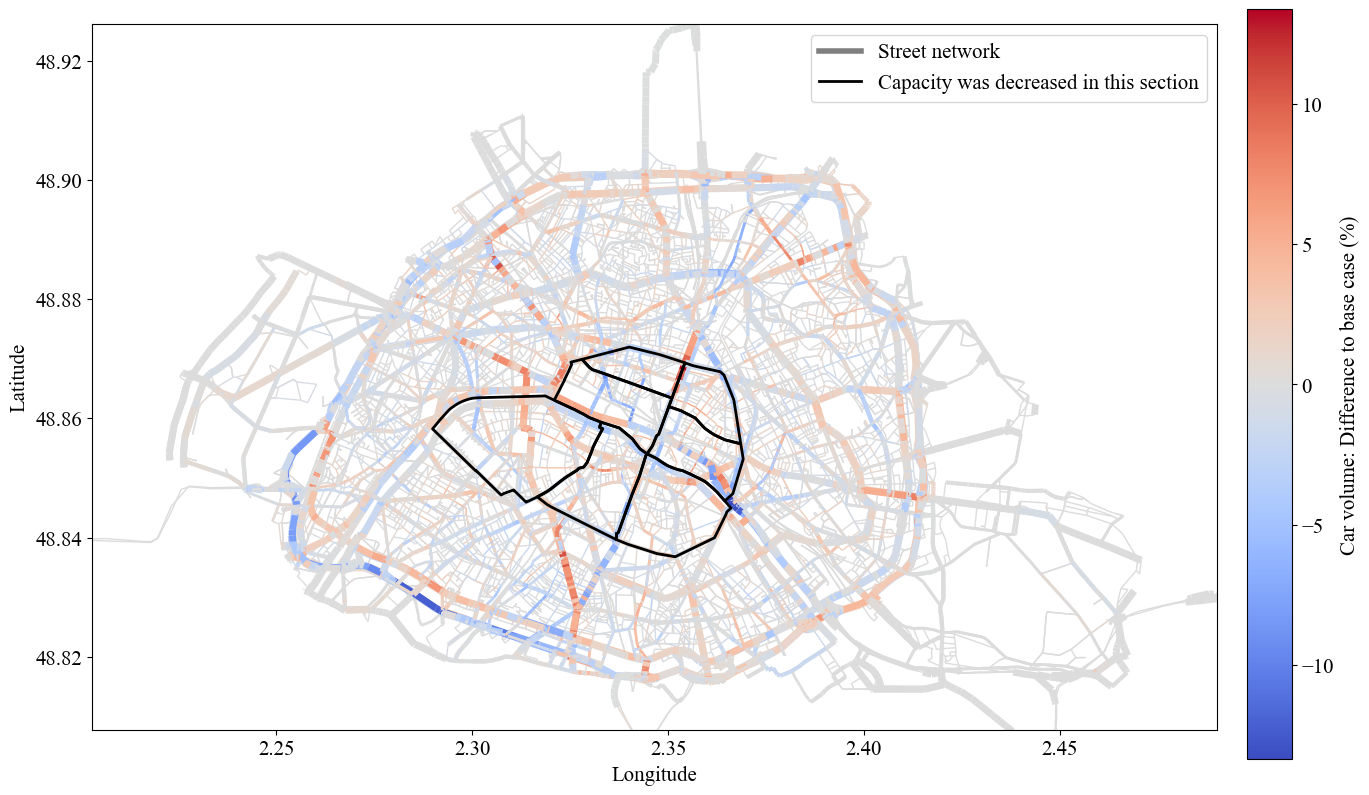

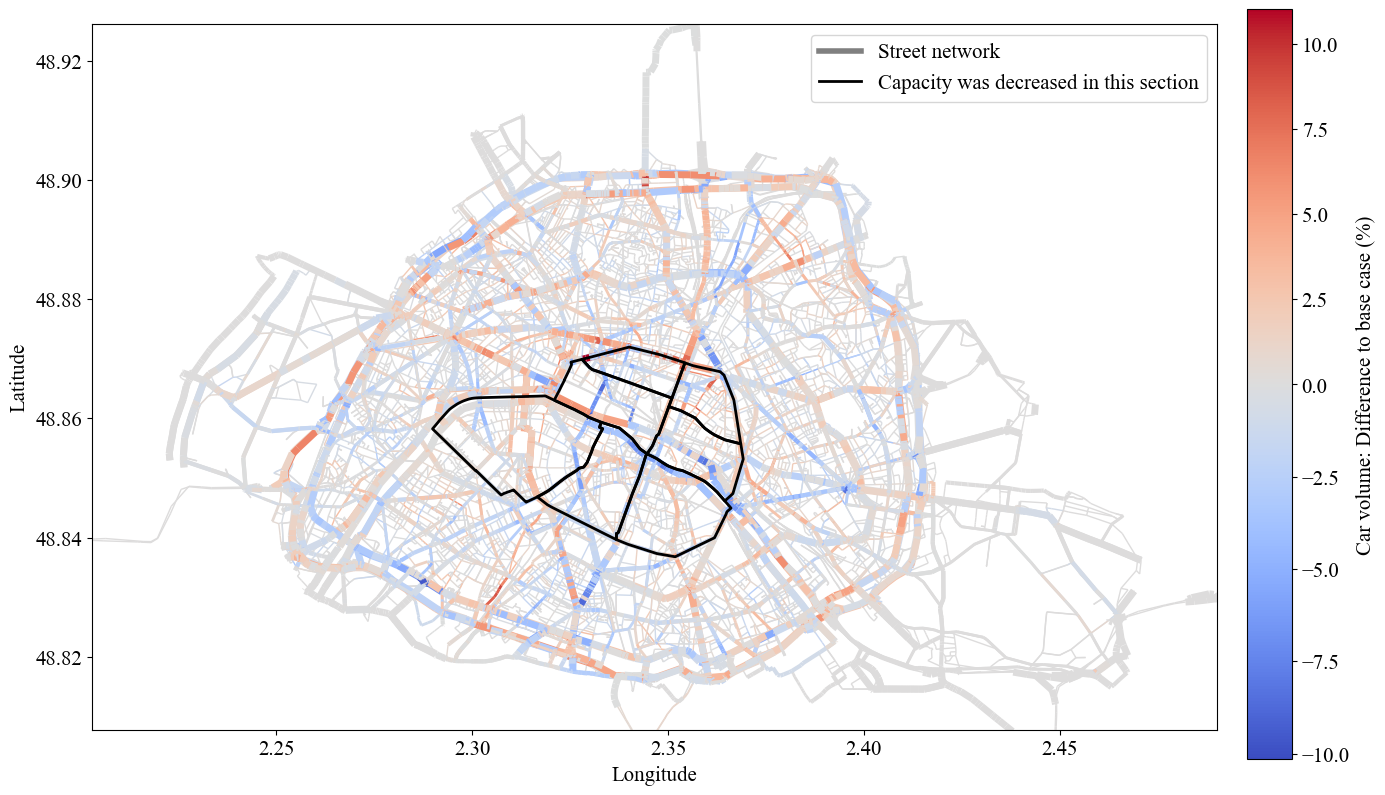

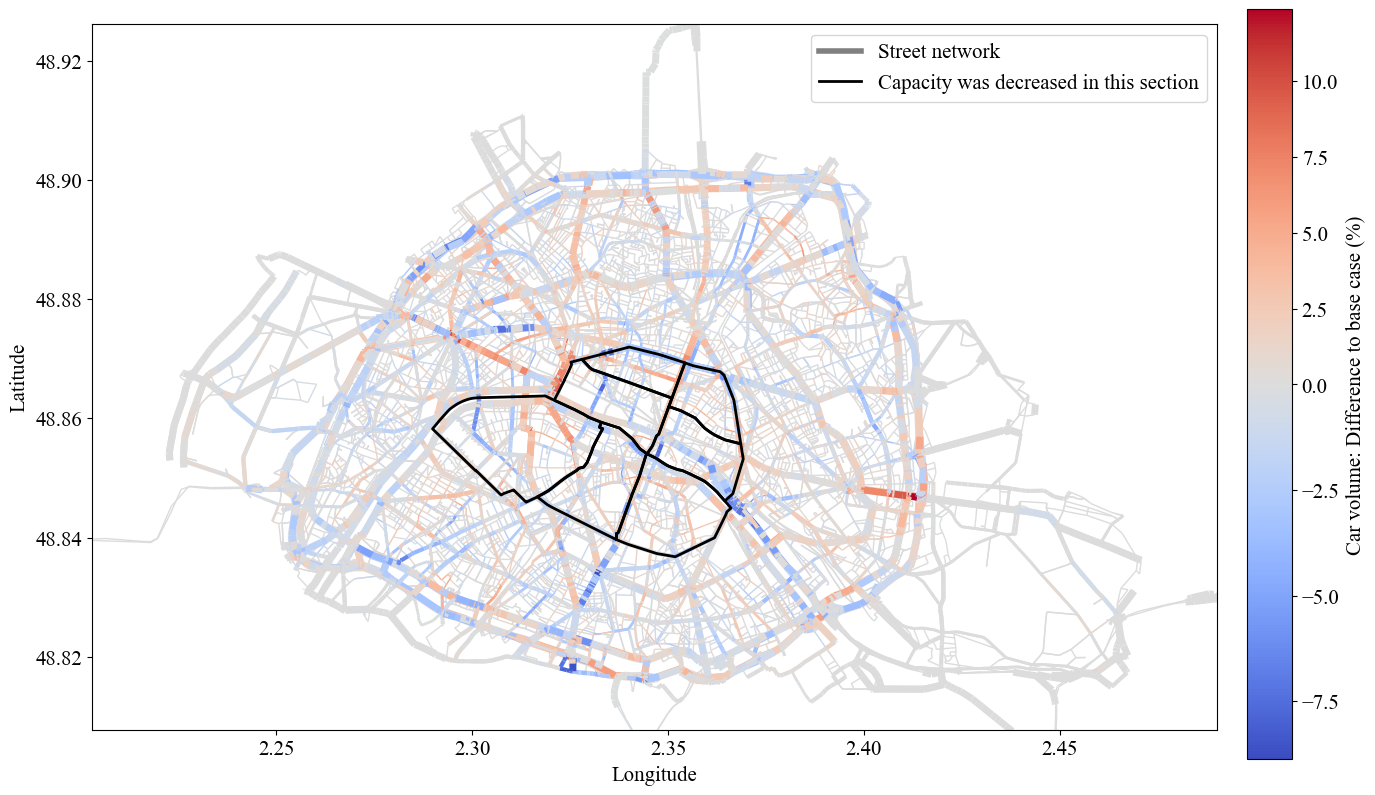

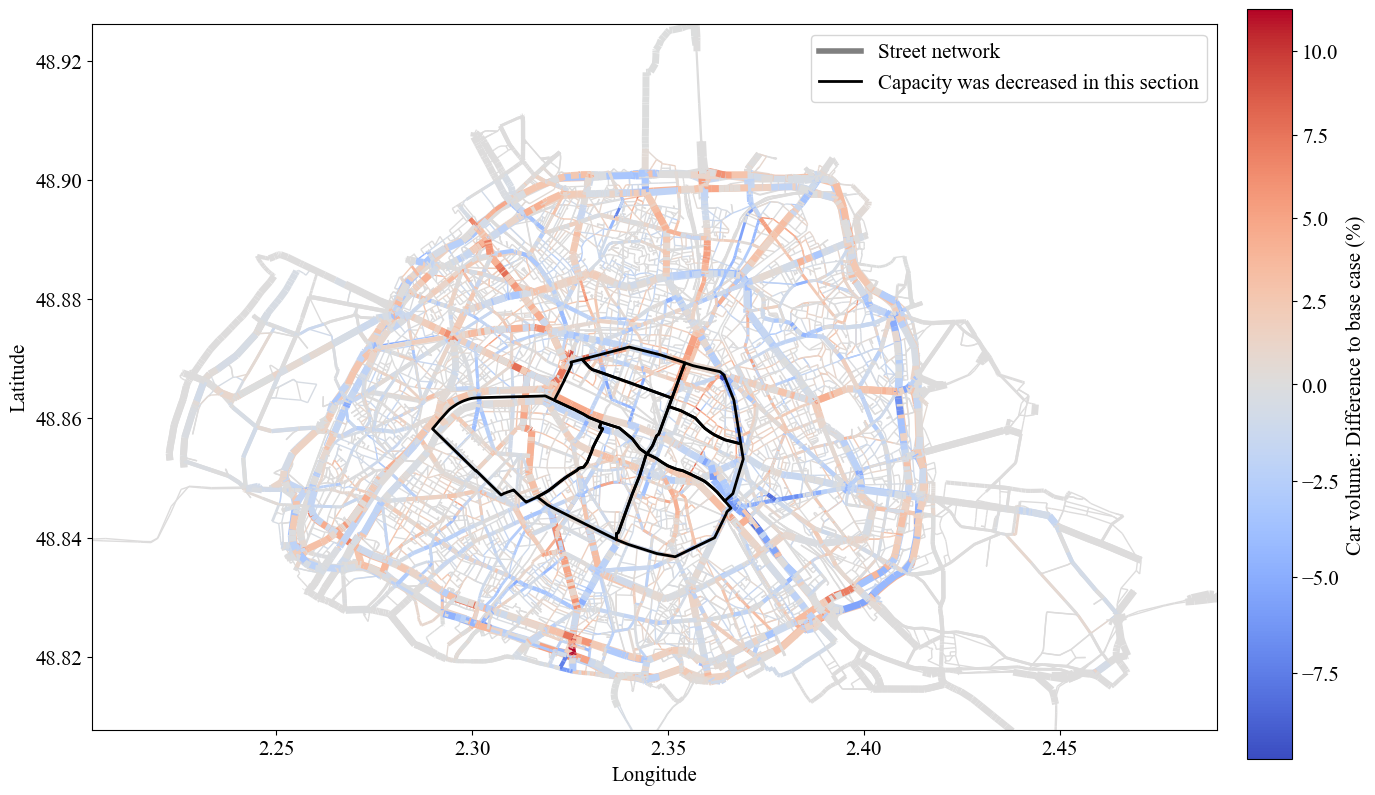

In [10]:
# # Plot the difference for the first random seed as an example

# hf.plot_combined_output(gdf_input=diff_mean_gdf, column_to_plot="car_volume_difference", 
#                             save_it=False, number_to_plot=0, zone_to_plot = "this zone", is_predicted=True, alpha=0, use_fixed_norm=False, 
#                             fixed_norm_max = 5,
#                             known_districts = False, buffer = 0.0005, districts_of_interest=None)

# hf.plot_combined_output(gdf_input=diff_gdf, column_to_plot="car_volume_difference", 
#                             save_it=False, number_to_plot=0, zone_to_plot = "this zone", is_predicted=True, alpha=0, use_fixed_norm=False, 
#                             fixed_norm_max = 5,
#                             known_districts = False, buffer = 0.0005, districts_of_interest=None)

# hf.plot_combined_output(gdf_input=gdf_combined_capacity['1'], column_to_plot="car_volume_difference", 
#                             save_it=False, number_to_plot=0, zone_to_plot = "this zone", is_predicted=True, alpha=0, use_fixed_norm=False, 
#                             fixed_norm_max = 5,
#                             known_districts = False, buffer = 0.0005, districts_of_interest=None)

# hf.plot_combined_output(gdf_input=gdf_combined_capacity['2'], column_to_plot="car_volume_difference", 
#                             save_it=False, number_to_plot=0, zone_to_plot = "this zone", is_predicted=True, alpha=0, use_fixed_norm=False, 
#                             fixed_norm_max = 5,
#                             known_districts = False, buffer = 0.0005, districts_of_interest=None)

# hf.plot_combined_output(gdf_input=gdf_combined_capacity['3'], column_to_plot="car_volume_difference", 
#                             save_it=False, number_to_plot=0, zone_to_plot = "this zone", is_predicted=True, alpha=0, use_fixed_norm=False, 
#                             fixed_norm_max = 5,
#                             known_districts = False, buffer = 0.0005, districts_of_interest=None)

# hf.plot_combined_output(gdf_input=gdf_combined_capacity['4'], column_to_plot="car_volume_difference", 
#                             save_it=False, number_to_plot=0, zone_to_plot = "this zone", is_predicted=True, alpha=0, use_fixed_norm=False, 
#                             fixed_norm_max = 5,
#                             known_districts = False, buffer = 0.0005, districts_of_interest=None)

# hf.plot_combined_output(gdf_input=gdf_combined_capacity['5'], column_to_plot="car_volume_difference", 
#                             save_it=False, number_to_plot=0, zone_to_plot = "this zone", is_predicted=True, alpha=0, use_fixed_norm=False, 
#                             fixed_norm_max = 5,
#                             known_districts = False, buffer = 0.0005, districts_of_interest=None)